# Notebook 04 — Pig Latin LoRA Multi-Model Benchmark (Tinker + W&B)

**Goal:** Compare multiple base models on the same dataset and training setup, tracking:
- training loss curves
- wall time / step time
- a simple quality metric (exact match on a small validation set)
- a simple “cost proxy” (completion tokens per epoch)

**Models tested:**
- meta-llama/Llama-3.2-3B
- Qwen/Qwen3-4B-Instruct-2507
- Qwen/Qwen3-30B-A3B-Instruct-2507

**Workflow:**
1) Load environment + initialize Tinker client  
2) Load dataset + sanity check  
3) Define experiment matrix  
4) Define helpers + training/eval function  
5) Run a single smoke test  
6) Run the full matrix + log to W&B (optional)

This notebook can run in REPORT MODE without retraining.

In [15]:
import os
import json
import time
import random
from datetime import datetime
from pathlib import Path

import numpy as np
from dotenv import load_dotenv

import tinker
from tinker import types

import wandb

import matplotlib.pyplot as plt

## 1) Environment + Tinker client

We explicitly load `.env` from the repo root (not the current notebook folder), then create a single `service_client`.
This avoids “API key not found” and avoids re-creating sessions repeatedly.

In [2]:
def find_repo_root(start=None):
    p = Path(start or Path.cwd()).resolve()
    for parent in [p, *p.parents]:
        if (parent / ".git").exists() or (parent / "pyproject.toml").exists():
            return parent
    return p

REPO_ROOT = find_repo_root()
ENV_PATH = REPO_ROOT / ".env"

print("REPO_ROOT:", REPO_ROOT)
print(".env exists:", ENV_PATH.exists())

load_dotenv(dotenv_path=ENV_PATH, override=True)

api_key = os.getenv("TINKER_API_KEY")
print("TINKER_API_KEY present:", bool(api_key))
print("TINKER_API_KEY startswith:", (api_key or "")[:6])

assert api_key, "Missing TINKER_API_KEY. Put it in repo-root .env as TINKER_API_KEY=..."

service_client = tinker.ServiceClient(api_key=api_key)
print("ServiceClient ready ✅")

REPO_ROOT: C:\Users\user\Desktop\tinker-hello-world
.env exists: True
TINKER_API_KEY present: True
TINKER_API_KEY startswith: tml-CD
ServiceClient ready ✅


## Tiny guard to prevent training run duplicates

In [3]:
RUN_TRAINING = False   # <- keep False for demo/report work
RUN_ANALYSIS = True

## 2) Dataset

We load `data/piglatin/sample.jsonl` and verify it contains `{ "input": ..., "output": ... }` rows.

In [4]:
DATA_PATH = REPO_ROOT / "data" / "piglatin" / "sample.jsonl"
print("DATA_PATH:", DATA_PATH)
print("Exists:", DATA_PATH.exists())
assert DATA_PATH.exists(), f"Missing dataset at {DATA_PATH}"

def read_jsonl(path):
    path = Path(path)
    rows = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    return rows

rows = read_jsonl(DATA_PATH)
print("Rows:", len(rows))
print("First row keys:", rows[0].keys())
print("First row sample:", rows[0])

assert "input" in rows[0] and "output" in rows[0], "Dataset rows must contain 'input' and 'output'"

DATA_PATH: C:\Users\user\Desktop\tinker-hello-world\data\piglatin\sample.jsonl
Exists: True
Rows: 300
First row keys: dict_keys(['input', 'output'])
First row sample: {'input': 'Translate this to Pig Latin:\nHaving assembled the senate, he reminded them of the injustice of his', 'output': 'aving-Hay assembled-ay e-thay enate-say, e-hay eminded-ray em-thay of-ay e-thay injustice-ay of-ay is-hay'}


## 3) Experiment matrix

We define:
- which base models to test
- training presets (light vs baseline)
- safe overrides for the 30B model
- a run naming scheme

In [6]:
WANDB_PROJECT = "tinker-hello-world"
WANDB_ENTITY = "itprodirect"
WANDB_MODE = "online"        # use "offline" if you want
WANDB_GROUP = "piglatin-multimodel-benchmark-v1"
USE_WANDB = False            # keep False for smoke test; turn True later

BASE_MODELS = [
    "meta-llama/Llama-3.2-3B",
    "Qwen/Qwen3-4B-Instruct-2507",
    "Qwen/Qwen3-30B-A3B-Instruct-2507",
]

PRESETS = {
    "light": dict(max_train_rows=120, lora_rank=8,  lora_alpha=16, learning_rate=2e-4, num_epochs=2, batch_size=8),
    "baseline": dict(max_train_rows=300, lora_rank=16, lora_alpha=32, learning_rate=1e-4, num_epochs=3, batch_size=8),
}

MODEL_OVERRIDES = {
    "Qwen/Qwen3-30B-A3B-Instruct-2507": dict(batch_size=4, max_train_rows=120),
}

EXPERIMENT_MATRIX = []
for m in BASE_MODELS:
    EXPERIMENT_MATRIX.append((m, "light"))
for m in ["meta-llama/Llama-3.2-3B", "Qwen/Qwen3-4B-Instruct-2507"]:
    EXPERIMENT_MATRIX.append((m, "baseline"))

def make_run_name(base_model: str, preset: str) -> str:
    short = base_model.split("/")[-1]
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    return f"piglatin-{preset}-{short}-{ts}"

print("Planned runs:")
for m, p in EXPERIMENT_MATRIX:
    print(" -", m, p)

Planned runs:
 - meta-llama/Llama-3.2-3B light
 - Qwen/Qwen3-4B-Instruct-2507 light
 - Qwen/Qwen3-30B-A3B-Instruct-2507 light
 - meta-llama/Llama-3.2-3B baseline
 - Qwen/Qwen3-4B-Instruct-2507 baseline


4) Training example format

We train next-token prediction where:

- prompt tokens are weighted **0**
- completion tokens are weighted **1**

This forces the loss to focus on the Pig Latin answer portion (not the prompt text).

In [8]:
# 4) Training example format (prompt weight=0, completion weight=1)

from tinker import types
import numpy as np

def process_example(example: dict, tokenizer) -> types.Datum:
    """
    Build a next-token prediction datum:
    - Prompt tokens are weight 0 (no loss)
    - Completion tokens are weight 1 (loss)
    """
    prompt = f"English: {example['input']}\nPig Latin:"
    prompt_tokens = tokenizer.encode(prompt, add_special_tokens=True)
    prompt_weights = [0] * len(prompt_tokens)

    completion_tokens = tokenizer.encode(f" {example['output']}\n", add_special_tokens=False)
    completion_weights = [1] * len(completion_tokens)

    tokens = prompt_tokens + completion_tokens
    weights = prompt_weights + completion_weights

    # Shift for next-token prediction
    input_tokens = tokens[:-1]
    target_tokens = tokens[1:]
    weights = weights[1:]  # align with targets

    return types.Datum(
        model_input=types.ModelInput.from_ints(tokens=input_tokens),
        loss_fn_inputs=dict(weights=weights, target_tokens=target_tokens),
    )

def _as_1d(x) -> np.ndarray:
    """Force scalars / tuples / lists / arrays into a 1D numpy array."""
    if hasattr(x, "tolist"):
        x = x.tolist()
    arr = np.asarray(x)
    return arr.reshape(-1)

def norm(s: str) -> str:
    """Normalize strings for exact-match comparisons."""
    return " ".join(s.strip().lower().split())

## 5) run_one() — train + evaluate one configuration

This cell defines `run_one()` only. It intentionally **does not** overwrite the experiment-matrix globals (WANDB_*, PRESETS, MODEL_OVERRIDES, etc.).

Key design decisions:
- `data_path=None` (defaults to repo `data/piglatin/sample.jsonl`)
- cost proxy is computed from completion-token weights (not Tinker internals)
- W&B logging is controlled by your global `USE_WANDB`

In [9]:
# =========================
# 5) Core training + eval
# =========================

import json
import time
import random
from datetime import datetime
from pathlib import Path

import numpy as np

import tinker
from tinker import types

# Optional: W&B
try:
    import wandb
except Exception:
    wandb = None

# Optional: dotenv (loads TINKER_API_KEY if you use a .env file)
try:
    from dotenv import load_dotenv
except Exception:
    load_dotenv = None


# ---------- Paths / env ----------
def find_repo_root(start: str | Path | None = None) -> Path:
    p = Path(start or Path.cwd()).resolve()
    for parent in [p, *p.parents]:
        if (parent / ".git").exists() or (parent / "pyproject.toml").exists():
            return parent
    return p


REPO_ROOT = find_repo_root()
ENV_PATH = REPO_ROOT / ".env"

if load_dotenv is not None and ENV_PATH.exists():
    load_dotenv(dotenv_path=ENV_PATH, override=True)

DEFAULT_DATA_PATH = str(REPO_ROOT / "data" / "piglatin" / "sample.jsonl")


# ---------- Helpers ----------
def read_jsonl(path: str | Path) -> list[dict]:
    path = Path(path)
    rows = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
    return rows


def _as_1d(x) -> np.ndarray:
    """Force scalars / tuples / lists / arrays into a 1D numpy array."""
    if hasattr(x, "tolist"):
        x = x.tolist()
    arr = np.asarray(x)
    return arr.reshape(-1)


def norm(s: str) -> str:
    return " ".join(s.strip().lower().split())


def process_example(example: dict, tokenizer) -> types.Datum:
    """
    Next-token prediction datum:
    - prompt tokens weight 0 (no loss)
    - completion tokens weight 1 (loss)
    """
    prompt = f"English: {example['input']}\nPig Latin:"
    prompt_tokens = tokenizer.encode(prompt, add_special_tokens=True)
    prompt_weights = [0] * len(prompt_tokens)

    completion_tokens = tokenizer.encode(f" {example['output']}\n", add_special_tokens=False)
    completion_weights = [1] * len(completion_tokens)

    tokens = prompt_tokens + completion_tokens
    weights = prompt_weights + completion_weights

    # Shift for next-token prediction
    input_tokens = tokens[:-1]
    target_tokens = tokens[1:]
    weights = weights[1:]  # align with targets

    return types.Datum(
        model_input=types.ModelInput.from_ints(tokens=input_tokens),
        loss_fn_inputs=dict(weights=weights, target_tokens=target_tokens),
    )


def _get_global(name: str, default):
    return globals().get(name, default)


def run_one(
    base_model: str,
    preset_name: str,
    data_path: str | None = None,
    seed: int = 7,
    val_rows: int = 25,
):
    """
    Train + evaluate exactly one configuration.
    Uses experiment globals if present:
      WANDB_PROJECT, WANDB_ENTITY, WANDB_MODE, WANDB_GROUP, USE_WANDB
      PRESETS, MODEL_OVERRIDES, make_run_name
    """
    # ---- Required globals from earlier sections ----
    PRESETS = _get_global("PRESETS", None)
    if PRESETS is None or preset_name not in PRESETS:
        raise ValueError("Missing PRESETS or preset_name not found. Run Section 3 (Experiment matrix) first.")

    MODEL_OVERRIDES = _get_global("MODEL_OVERRIDES", {})
    make_run_name = _get_global("make_run_name", None)

    # ---- Data path ----
    if data_path is None:
        data_path = _get_global("DATA_PATH", DEFAULT_DATA_PATH)

    # ---- W&B globals ----
    WANDB_PROJECT = _get_global("WANDB_PROJECT", "tinker-hello-world")
    WANDB_ENTITY  = _get_global("WANDB_ENTITY", None)
    WANDB_MODE    = _get_global("WANDB_MODE", "online")
    WANDB_GROUP   = _get_global("WANDB_GROUP", "piglatin-multimodel-benchmark-v1")
    USE_WANDB     = _get_global("USE_WANDB", False)

    # ---- Client (reuse if you already created one earlier) ----
    service_client = _get_global("service_client", None) or tinker.ServiceClient()

    # ---- Config ----
    cfg = dict(PRESETS[preset_name])
    cfg.update(MODEL_OVERRIDES.get(base_model, {}))

    if make_run_name is None:
        def make_run_name(bm: str, ps: str) -> str:
            short = bm.split("/")[-1]
            ts = datetime.now().strftime("%Y%m%d_%H%M%S")
            return f"piglatin-{ps}-{short}-{ts}"

    run_name = make_run_name(base_model, preset_name)

    random.seed(seed)
    np.random.seed(seed)

    examples = read_jsonl(data_path)[: cfg["max_train_rows"]]
    random.shuffle(examples)

    val = examples[:val_rows]
    train = examples[val_rows:]
    assert len(train) > 0, "Train split is empty; increase max_train_rows or reduce val_rows."

    print("\n==============================")
    print("RUN:", run_name)
    print("MODEL:", base_model)
    print("CFG:", cfg)
    print("DATA:", data_path)
    print("USE_WANDB:", USE_WANDB)
    print("==============================")

    # ---- W&B init (optional) ----
    wandb_run = None
    if USE_WANDB and wandb is not None:
        wandb_run = wandb.init(
            project=WANDB_PROJECT,
            entity=WANDB_ENTITY,
            mode=WANDB_MODE,
            name=run_name,
            group=WANDB_GROUP,
            tags=[preset_name, base_model.split("/")[-1]],
            config=dict(
                base_model=base_model,
                preset=preset_name,
                **cfg,
                seed=seed,
                train_rows=len(train),
                val_rows=len(val),
            ),
        )

    # ---- Training client + tokenizer ----
    training_client = service_client.create_lora_training_client(
        base_model=base_model,
        rank=cfg["lora_rank"],
    )
    tokenizer = training_client.get_tokenizer()

    processed_train = [process_example(ex, tokenizer) for ex in train]

    # Cost proxy (weighted tokens == completion tokens)
    completion_tokens_per_epoch = int(
        sum(_as_1d(d.loss_fn_inputs["weights"]).sum() for d in processed_train)
    )

    num_examples = len(processed_train)
    steps_per_epoch = int(np.ceil(num_examples / cfg["batch_size"]))
    total_steps = cfg["num_epochs"] * steps_per_epoch

    t0 = time.perf_counter()
    global_step = 0
    step_times = []

    for epoch in range(cfg["num_epochs"]):
        random.shuffle(processed_train)

        for start in range(0, num_examples, cfg["batch_size"]):
            batch = processed_train[start : start + cfg["batch_size"]]

            st = time.perf_counter()

            fwdbwd_future = training_client.forward_backward(batch, loss_fn="cross_entropy")
            optim_future = training_client.optim_step(types.AdamParams(learning_rate=cfg["learning_rate"]))

            fwdbwd_result = fwdbwd_future.result()
            optim_future.result()

            logprobs = np.concatenate([_as_1d(out["logprobs"]) for out in fwdbwd_result.loss_fn_outputs])
            weights  = np.concatenate([_as_1d(ex.loss_fn_inputs["weights"]) for ex in batch])

            if logprobs.shape[0] != weights.shape[0]:
                raise ValueError(f"Length mismatch: logprobs={logprobs.shape} weights={weights.shape}")

            loss = -float(np.dot(logprobs, weights) / weights.sum())

            global_step += 1
            dt = time.perf_counter() - st
            step_times.append(dt)

            if USE_WANDB and wandb_run is not None:
                wandb.log(
                    {
                        "train/loss": loss,
                        "train/epoch": epoch + 1,
                        "train/step": global_step,
                        "perf/step_time_s": dt,
                        "perf/completion_tokens_per_epoch": completion_tokens_per_epoch,
                        "perf/est_completion_tokens_total": completion_tokens_per_epoch * cfg["num_epochs"],
                    },
                    step=global_step,
                )

            print(f"Epoch {epoch+1}/{cfg['num_epochs']} Step {global_step}/{total_steps} Loss {loss:.4f} StepTime {dt:.2f}s")

    wall_time_s = time.perf_counter() - t0
    avg_step_time_s = float(np.mean(step_times)) if step_times else None

    # Save adapter + sampling client
    sampling_client = training_client.save_weights_and_get_sampling_client(name=run_name)

    # ---- Eval ----
    params = types.SamplingParams(max_tokens=60, temperature=0.0, top_p=1.0)

    correct = 0
    rows_out = []

    for ex in val:
        prompt = f"English: {ex['input']}\nPig Latin:"
        prompt_tokens = tokenizer.encode(prompt, add_special_tokens=True)
        model_input = types.ModelInput.from_ints(tokens=prompt_tokens)

        result = sampling_client.sample(
            prompt=model_input,
            sampling_params=params,
            num_samples=1
        ).result()

        seq_tokens = result.sequences[0].tokens

        # Strip prompt prefix if present
        if len(seq_tokens) >= len(prompt_tokens) and seq_tokens[:len(prompt_tokens)] == prompt_tokens:
            new_tokens = seq_tokens[len(prompt_tokens):]
        else:
            new_tokens = seq_tokens

        decoded_new = tokenizer.decode(new_tokens).strip()
        pred = decoded_new.splitlines()[0].strip() if decoded_new else ""

        gold = ex["output"].strip()
        is_ok = (norm(pred) == norm(gold))

        correct += int(is_ok)
        rows_out.append([ex["input"], gold, pred, is_ok])

        # Print first 5 samples for sanity
        if len(rows_out) <= 5:
            print("----")
            print("IN  :", ex["input"])
            print("GOLD:", gold)
            print("PRED:", pred if pred else "<EMPTY>")
            print("OK? :", is_ok)

    exact_match = correct / len(val) if val else 0.0

    if USE_WANDB and wandb_run is not None:
        table = wandb.Table(columns=["input", "expected", "pred", "ok"], data=rows_out[:10])
        wandb.log(
            {
                "eval/exact_match_norm": exact_match,
                "eval/samples": table,
                "perf/wall_time_s": wall_time_s,
                "perf/avg_step_time_s": avg_step_time_s,
            }
        )
        wandb_run.summary["perf/wall_time_s"] = wall_time_s
        wandb_run.summary["eval/exact_match_norm"] = exact_match
        wandb.finish()

    print(f"Done. wall_time_s={wall_time_s:.1f} eval_exact_match_norm={exact_match:.3f}")
    return {
        "run_name": run_name,
        "base_model": base_model,
        "preset": preset_name,
        "wall_time_s": wall_time_s,
        "avg_step_time_s": avg_step_time_s,
        "exact_match_norm": exact_match,
    }

## 6) Smoke test

Run exactly one small experiment (**no W&B**) to verify:
- dataset loads
- training loop runs
- adapter saves
- evaluation produces a metric

If this passes, we can confidently run the full matrix with W&B.

In [10]:
RUN_SMOKE = True

if RUN_SMOKE:
    USE_WANDB = False  # force off for smoke test

    smoke_result = run_one(
        base_model="meta-llama/Llama-3.2-3B",
        preset_name="light",
        val_rows=10,   # faster
        seed=7,
    )

    smoke_result
else:
    print("Skipping smoke test (RUN_SMOKE=False).")


RUN: piglatin-light-Llama-3.2-3B-20251212_122829
MODEL: meta-llama/Llama-3.2-3B
CFG: {'max_train_rows': 120, 'lora_rank': 8, 'lora_alpha': 16, 'learning_rate': 0.0002, 'num_epochs': 2, 'batch_size': 8}
DATA: C:\Users\user\Desktop\tinker-hello-world\data\piglatin\sample.jsonl
USE_WANDB: False
Epoch 1/2 Step 1/28 Loss 3.2360 StepTime 1.11s
Epoch 1/2 Step 2/28 Loss 2.8872 StepTime 1.19s
Epoch 1/2 Step 3/28 Loss 2.4037 StepTime 1.19s
Epoch 1/2 Step 4/28 Loss 1.9843 StepTime 1.26s
Epoch 1/2 Step 5/28 Loss 1.6920 StepTime 1.18s
Epoch 1/2 Step 6/28 Loss 1.4705 StepTime 1.12s
Epoch 1/2 Step 7/28 Loss 1.3142 StepTime 1.18s
Epoch 1/2 Step 8/28 Loss 1.1682 StepTime 1.17s
Epoch 1/2 Step 9/28 Loss 1.0955 StepTime 1.22s
Epoch 1/2 Step 10/28 Loss 0.9103 StepTime 1.28s
Epoch 1/2 Step 11/28 Loss 0.8582 StepTime 1.32s
Epoch 1/2 Step 12/28 Loss 0.7154 StepTime 1.21s
Epoch 1/2 Step 13/28 Loss 0.5864 StepTime 1.26s
Epoch 1/2 Step 14/28 Loss 0.6813 StepTime 1.23s
Epoch 2/2 Step 15/28 Loss 0.5003 StepTime 1

## 7) Full experiment matrix (with W&B)

Now we run every (model, preset) in `EXPERIMENT_MATRIX` and log to Weights & Biases.

Tip: keep an eye on the 30B run — it uses safer overrides by default.

- evaluation runs

In [11]:
import pandas as pd

RUN_TRAINING = True

if RUN_TRAINING:
    USE_WANDB = True  # enable W&B for the real runs

    results = []
    for base_model, preset in EXPERIMENT_MATRIX:
        print("\n\n### RUNNING:", base_model, preset)
        try:
            out = run_one(base_model=base_model, preset_name=preset, seed=7, val_rows=25)
            results.append(out)
        except Exception as e:
            print("!!! FAILED:", base_model, preset, "->", repr(e))
            results.append({
                "run_name": None,
                "base_model": base_model,
                "preset": preset,
                "wall_time_s": None,
                "avg_step_time_s": None,
                "exact_match_norm": None,
                "error": repr(e),
            })

    df_local = pd.DataFrame(results)
    display(df_local.sort_values("exact_match_norm", ascending=False))
else:
    print("Skipping training (RUN_TRAINING=False).")



### RUNNING: meta-llama/Llama-3.2-3B light

RUN: piglatin-light-Llama-3.2-3B-20251212_124034
MODEL: meta-llama/Llama-3.2-3B
CFG: {'max_train_rows': 120, 'lora_rank': 8, 'lora_alpha': 16, 'learning_rate': 0.0002, 'num_epochs': 2, 'batch_size': 8}
DATA: C:\Users\user\Desktop\tinker-hello-world\data\piglatin\sample.jsonl
USE_WANDB: True


wandb: Currently logged in as: nick99 (itprodirect) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/2 Step 1/24 Loss 3.2464 StepTime 1.21s
Epoch 1/2 Step 2/24 Loss 2.9429 StepTime 1.22s
Epoch 1/2 Step 3/24 Loss 2.3487 StepTime 1.20s
Epoch 1/2 Step 4/24 Loss 1.9152 StepTime 1.14s
Epoch 1/2 Step 5/24 Loss 1.7097 StepTime 1.25s
Epoch 1/2 Step 6/24 Loss 1.5891 StepTime 1.24s
Epoch 1/2 Step 7/24 Loss 1.3890 StepTime 1.08s
Epoch 1/2 Step 8/24 Loss 1.0961 StepTime 1.09s
Epoch 1/2 Step 9/24 Loss 1.0075 StepTime 1.18s
Epoch 1/2 Step 10/24 Loss 0.8410 StepTime 1.19s
Epoch 1/2 Step 11/24 Loss 0.5656 StepTime 1.17s
Epoch 1/2 Step 12/24 Loss 0.5703 StepTime 1.19s
Epoch 2/2 Step 13/24 Loss 0.4717 StepTime 1.25s
Epoch 2/2 Step 14/24 Loss 0.3353 StepTime 1.17s
Epoch 2/2 Step 15/24 Loss 0.3556 StepTime 1.19s
Epoch 2/2 Step 16/24 Loss 0.3409 StepTime 1.23s
Epoch 2/2 Step 17/24 Loss 0.2117 StepTime 1.19s
Epoch 2/2 Step 18/24 Loss 0.4053 StepTime 1.33s
Epoch 2/2 Step 19/24 Loss 0.3042 StepTime 1.18s
Epoch 2/2 Step 20/24 Loss 0.4137 StepTime 1.18s
Epoch 2/2 Step 21/24 Loss 0.3117 StepTime 1.11s
E

eval/exact_match_norm,▁
perf/avg_step_time_s,▁
perf/completion_tokens_per_epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perf/est_completion_tokens_total,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perf/step_time_s,▅▅▄▃▆▆▁▁▄▄▄▄▆▄▄▅▄█▄▄▂▄▄▄
perf/wall_time_s,▁
train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁████████████
train/loss,█▇▆▅▄▄▄▃▃▂▂▂▂▁▁▁▁▂▁▂▁▁▁▁
train/step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
eval/exact_match_norm,0
perf/avg_step_time_s,1.18844


Done. wall_time_s=28.6 eval_exact_match_norm=0.000


### RUNNING: Qwen/Qwen3-4B-Instruct-2507 light

RUN: piglatin-light-Qwen3-4B-Instruct-2507-20251212_124208
MODEL: Qwen/Qwen3-4B-Instruct-2507
CFG: {'max_train_rows': 120, 'lora_rank': 8, 'lora_alpha': 16, 'learning_rate': 0.0002, 'num_epochs': 2, 'batch_size': 8}
DATA: C:\Users\user\Desktop\tinker-hello-world\data\piglatin\sample.jsonl
USE_WANDB: True


Epoch 1/2 Step 1/24 Loss 2.3160 StepTime 1.71s
Epoch 1/2 Step 2/24 Loss 2.4483 StepTime 1.66s
Epoch 1/2 Step 3/24 Loss 1.4622 StepTime 1.48s
Epoch 1/2 Step 4/24 Loss 1.2635 StepTime 1.72s
Epoch 1/2 Step 5/24 Loss 0.9200 StepTime 1.49s
Epoch 1/2 Step 6/24 Loss 0.7974 StepTime 1.53s
Epoch 1/2 Step 7/24 Loss 0.7069 StepTime 1.54s
Epoch 1/2 Step 8/24 Loss 0.4907 StepTime 1.62s
Epoch 1/2 Step 9/24 Loss 0.5689 StepTime 1.47s
Epoch 1/2 Step 10/24 Loss 0.4895 StepTime 1.47s
Epoch 1/2 Step 11/24 Loss 0.2038 StepTime 1.49s
Epoch 1/2 Step 12/24 Loss 0.1711 StepTime 1.48s
Epoch 2/2 Step 13/24 Loss 0.1830 StepTime 1.46s
Epoch 2/2 Step 14/24 Loss 0.2119 StepTime 1.44s
Epoch 2/2 Step 15/24 Loss 0.1275 StepTime 1.49s
Epoch 2/2 Step 16/24 Loss 0.1285 StepTime 1.51s
Epoch 2/2 Step 17/24 Loss 0.0901 StepTime 1.46s
Epoch 2/2 Step 18/24 Loss 0.1498 StepTime 1.47s
Epoch 2/2 Step 19/24 Loss 0.1804 StepTime 1.75s
Epoch 2/2 Step 20/24 Loss 0.3026 StepTime 1.53s
Epoch 2/2 Step 21/24 Loss 0.2039 StepTime 1.55s
E

eval/exact_match_norm,▁
perf/avg_step_time_s,▁
perf/completion_tokens_per_epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perf/est_completion_tokens_total,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perf/step_time_s,▇▆▂▇▂▃▃▅▂▂▂▂▁▁▂▃▂▂█▃▃▂▁█
perf/wall_time_s,▁
train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁████████████
train/loss,██▅▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁
train/step,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
eval/exact_match_norm,0.08
perf/avg_step_time_s,1.54227


Done. wall_time_s=37.1 eval_exact_match_norm=0.080


### RUNNING: Qwen/Qwen3-30B-A3B-Instruct-2507 light

RUN: piglatin-light-Qwen3-30B-A3B-Instruct-2507-20251212_124350
MODEL: Qwen/Qwen3-30B-A3B-Instruct-2507
CFG: {'max_train_rows': 120, 'lora_rank': 8, 'lora_alpha': 16, 'learning_rate': 0.0002, 'num_epochs': 2, 'batch_size': 4}
DATA: C:\Users\user\Desktop\tinker-hello-world\data\piglatin\sample.jsonl
USE_WANDB: True


Epoch 1/2 Step 1/48 Loss 0.7406 StepTime 2.34s
Epoch 1/2 Step 2/48 Loss 0.7420 StepTime 3.28s
Epoch 1/2 Step 3/48 Loss 0.4474 StepTime 3.15s
Epoch 1/2 Step 4/48 Loss 0.8899 StepTime 3.16s
Epoch 1/2 Step 5/48 Loss 0.4542 StepTime 2.62s
Epoch 1/2 Step 6/48 Loss 0.1545 StepTime 2.08s
Epoch 1/2 Step 7/48 Loss 0.3458 StepTime 1.99s
Epoch 1/2 Step 8/48 Loss 0.3086 StepTime 2.20s
Epoch 1/2 Step 9/48 Loss 0.2674 StepTime 2.05s
Epoch 1/2 Step 10/48 Loss 0.1756 StepTime 2.01s
Epoch 1/2 Step 11/48 Loss 0.1984 StepTime 2.07s
Epoch 1/2 Step 12/48 Loss 0.3278 StepTime 2.04s
Epoch 1/2 Step 13/48 Loss 0.2864 StepTime 2.00s
Epoch 1/2 Step 14/48 Loss 0.2851 StepTime 1.97s
Epoch 1/2 Step 15/48 Loss 0.2438 StepTime 2.46s
Epoch 1/2 Step 16/48 Loss 0.1169 StepTime 2.00s
Epoch 1/2 Step 17/48 Loss 0.1749 StepTime 2.24s
Epoch 1/2 Step 18/48 Loss 0.1752 StepTime 2.12s
Epoch 1/2 Step 19/48 Loss 0.1128 StepTime 1.99s
Epoch 1/2 Step 20/48 Loss 0.1250 StepTime 1.97s
Epoch 1/2 Step 21/48 Loss 0.0882 StepTime 2.06s
E

eval/exact_match_norm,▁
perf/avg_step_time_s,▁
perf/completion_tokens_per_epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perf/est_completion_tokens_total,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perf/step_time_s,▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁█▄
perf/wall_time_s,▁
train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
train/loss,▇▇▄█▅▄▃▃▂▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▂▂▁▁▁▁▂▁▂▁▁▂▁▁
train/step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
eval/exact_match_norm,0.32
perf/avg_step_time_s,2.69313


Done. wall_time_s=129.5 eval_exact_match_norm=0.320


### RUNNING: meta-llama/Llama-3.2-3B baseline

RUN: piglatin-baseline-Llama-3.2-3B-20251212_124912
MODEL: meta-llama/Llama-3.2-3B
CFG: {'max_train_rows': 300, 'lora_rank': 16, 'lora_alpha': 32, 'learning_rate': 0.0001, 'num_epochs': 3, 'batch_size': 8}
DATA: C:\Users\user\Desktop\tinker-hello-world\data\piglatin\sample.jsonl
USE_WANDB: True


Epoch 1/3 Step 1/105 Loss 3.5147 StepTime 1.25s
Epoch 1/3 Step 2/105 Loss 3.2140 StepTime 1.27s
Epoch 1/3 Step 3/105 Loss 2.8068 StepTime 1.24s
Epoch 1/3 Step 4/105 Loss 2.2775 StepTime 1.43s
Epoch 1/3 Step 5/105 Loss 2.0735 StepTime 1.25s
Epoch 1/3 Step 6/105 Loss 2.0170 StepTime 1.09s
Epoch 1/3 Step 7/105 Loss 1.6870 StepTime 1.19s
Epoch 1/3 Step 8/105 Loss 1.9437 StepTime 1.24s
Epoch 1/3 Step 9/105 Loss 1.6143 StepTime 1.22s
Epoch 1/3 Step 10/105 Loss 1.3037 StepTime 1.14s
Epoch 1/3 Step 11/105 Loss 1.3167 StepTime 1.05s
Epoch 1/3 Step 12/105 Loss 1.0453 StepTime 1.16s
Epoch 1/3 Step 13/105 Loss 0.9121 StepTime 1.29s
Epoch 1/3 Step 14/105 Loss 0.9772 StepTime 1.17s
Epoch 1/3 Step 15/105 Loss 0.8836 StepTime 1.28s
Epoch 1/3 Step 16/105 Loss 0.9388 StepTime 1.23s
Epoch 1/3 Step 17/105 Loss 0.7614 StepTime 1.25s
Epoch 1/3 Step 18/105 Loss 0.6911 StepTime 1.19s
Epoch 1/3 Step 19/105 Loss 0.8142 StepTime 1.06s
Epoch 1/3 Step 20/105 Loss 0.7479 StepTime 1.16s
Epoch 1/3 Step 21/105 Loss 0.

eval/exact_match_norm,▁
perf/avg_step_time_s,▁
perf/completion_tokens_per_epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perf/est_completion_tokens_total,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perf/step_time_s,▃▅▁▂▃▂▂▃▂▃▂▂▃▃▁▂▂▁▂▂▁▂▃▂▂▂▃▃▂▃▃▃▂█▃▂▂▁▂▂
perf/wall_time_s,▁
train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅█████████████
train/loss,█▇▅▅▄▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
eval/exact_match_norm,0.24
perf/avg_step_time_s,1.20392


Done. wall_time_s=126.8 eval_exact_match_norm=0.240


### RUNNING: Qwen/Qwen3-4B-Instruct-2507 baseline

RUN: piglatin-baseline-Qwen3-4B-Instruct-2507-20251212_125218
MODEL: Qwen/Qwen3-4B-Instruct-2507
CFG: {'max_train_rows': 300, 'lora_rank': 16, 'lora_alpha': 32, 'learning_rate': 0.0001, 'num_epochs': 3, 'batch_size': 8}
DATA: C:\Users\user\Desktop\tinker-hello-world\data\piglatin\sample.jsonl
USE_WANDB: True


Epoch 1/3 Step 1/105 Loss 3.1657 StepTime 1.54s
Epoch 1/3 Step 2/105 Loss 2.2801 StepTime 1.61s
Epoch 1/3 Step 3/105 Loss 1.8703 StepTime 1.49s
Epoch 1/3 Step 4/105 Loss 1.4698 StepTime 1.48s
Epoch 1/3 Step 5/105 Loss 0.9607 StepTime 1.49s
Epoch 1/3 Step 6/105 Loss 1.1455 StepTime 1.46s
Epoch 1/3 Step 7/105 Loss 1.0501 StepTime 1.61s
Epoch 1/3 Step 8/105 Loss 1.0739 StepTime 1.45s
Epoch 1/3 Step 9/105 Loss 0.9084 StepTime 1.50s
Epoch 1/3 Step 10/105 Loss 0.6019 StepTime 1.60s
Epoch 1/3 Step 11/105 Loss 0.6468 StepTime 1.46s
Epoch 1/3 Step 12/105 Loss 0.5016 StepTime 1.47s
Epoch 1/3 Step 13/105 Loss 0.5530 StepTime 1.52s
Epoch 1/3 Step 14/105 Loss 0.5949 StepTime 1.48s
Epoch 1/3 Step 15/105 Loss 0.4602 StepTime 1.55s
Epoch 1/3 Step 16/105 Loss 0.5601 StepTime 1.47s
Epoch 1/3 Step 17/105 Loss 0.3620 StepTime 1.66s
Epoch 1/3 Step 18/105 Loss 0.3713 StepTime 1.46s
Epoch 1/3 Step 19/105 Loss 0.4288 StepTime 1.54s
Epoch 1/3 Step 20/105 Loss 0.4281 StepTime 1.45s
Epoch 1/3 Step 21/105 Loss 0.

eval/exact_match_norm,▁
perf/avg_step_time_s,▁
perf/completion_tokens_per_epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perf/est_completion_tokens_total,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
perf/step_time_s,▃▂▃▂▃▄▃▂▅▃▄▄▂▁▅▄▄▂▅▃▃▄▂▅█▂▄▄▄▅▂▄▃▃▃▆▄▃▅▄
perf/wall_time_s,▁
train/epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅████████████
train/loss,█▄▄▃▃▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/step,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇████
eval/exact_match_norm,0.24
perf/avg_step_time_s,1.52856


Done. wall_time_s=161.0 eval_exact_match_norm=0.240


,run_name,base_model,preset,wall_time_s,avg_step_time_s,exact_match_norm
2,piglatin-light-Qwen3-30B-A3B-Instruct-2507-202...,Qwen/Qwen3-30B-A3B-Instruct-2507,light,129.481849,2.693132,0.32
4,piglatin-baseline-Qwen3-4B-Instruct-2507-20251...,Qwen/Qwen3-4B-Instruct-2507,baseline,160.950016,1.528557,0.24
3,piglatin-baseline-Llama-3.2-3B-20251212_124912,meta-llama/Llama-3.2-3B,baseline,126.833512,1.203923,0.24
1,piglatin-light-Qwen3-4B-Instruct-2507-20251212...,Qwen/Qwen3-4B-Instruct-2507,light,37.119052,1.542274,0.08
0,piglatin-light-Llama-3.2-3B-20251212_124034,meta-llama/Llama-3.2-3B,light,28.620444,1.188445,0.00


## 8) Post-run leaderboard (pull from W&B)

Pull finished runs from W&B, filter to this notebook’s run naming convention, and build a leaderboard:
- accuracy (eval/exact_match_norm)
- wall time
- step time
- estimated completion tokens

In [12]:
import wandb
import pandas as pd

ENTITY  = WANDB_ENTITY
PROJECT = WANDB_PROJECT
GROUP   = WANDB_GROUP

api = wandb.Api()
runs = api.runs(f"{ENTITY}/{PROJECT}", {"state": "finished"})

rows = []
for r in runs:
    # filter to this notebook’s runs (and optionally group)
    if not (r.name or "").startswith("piglatin-"):
        continue
    if GROUP and (r.group != GROUP):
        continue

    s = dict(r.summary)
    c = dict(r.config)

    rows.append({
        "name": r.name,
        "id": r.id,
        "url": r.url,
        "base_model": c.get("base_model") or c.get("model") or c.get("model_name"),
        "preset": c.get("preset"),
        "eval/exact_match_norm": s.get("eval/exact_match_norm"),
        "perf/wall_time_s": s.get("perf/wall_time_s"),
        "perf/avg_step_time_s": s.get("perf/avg_step_time_s"),
        "perf/est_completion_tokens_total": s.get("perf/est_completion_tokens_total"),
    })

df_wandb = pd.DataFrame(rows)

df_wandb_sorted = df_wandb.sort_values("eval/exact_match_norm", ascending=False)
display(df_wandb_sorted.head(25))

,name,id,url,base_model,preset,eval/exact_match_norm,perf/wall_time_s,perf/avg_step_time_s,perf/est_completion_tokens_total
4,piglatin-baseline-Qwen3-4B-Instruct-2507-20251...,50rlky0e,https://wandb.ai/itprodirect/tinker-hello-worl...,Qwen/Qwen3-4B-Instruct-2507,baseline,0.36,192.906789,1.832790,33573
2,piglatin-light-Qwen3-30B-A3B-Instruct-2507-202...,qz48vlyt,https://wandb.ai/itprodirect/tinker-hello-worl...,Qwen/Qwen3-30B-A3B-Instruct-2507,light,0.32,108.945270,2.265083,7724
7,piglatin-light-Qwen3-30B-A3B-Instruct-2507-202...,ka1ke3sz,https://wandb.ai/itprodirect/tinker-hello-worl...,Qwen/Qwen3-30B-A3B-Instruct-2507,light,0.32,129.481849,2.693132,7724
8,piglatin-baseline-Llama-3.2-3B-20251212_124912,fvozjttu,https://wandb.ai/itprodirect/tinker-hello-worl...,meta-llama/Llama-3.2-3B,baseline,0.24,126.833512,1.203923,33498
9,piglatin-baseline-Qwen3-4B-Instruct-2507-20251...,yed1fcme,https://wandb.ai/itprodirect/tinker-hello-worl...,Qwen/Qwen3-4B-Instruct-2507,baseline,0.24,160.950016,1.528557,33573
3,piglatin-baseline-Llama-3.2-3B-20251211_225651,gw99zgsf,https://wandb.ai/itprodirect/tinker-hello-worl...,meta-llama/Llama-3.2-3B,baseline,0.20,124.723404,1.183409,33498
6,piglatin-light-Qwen3-4B-Instruct-2507-20251212...,g76cpwcz,https://wandb.ai/itprodirect/tinker-hello-worl...,Qwen/Qwen3-4B-Instruct-2507,light,0.08,37.119052,1.542274,7724
1,piglatin-light-Qwen3-4B-Instruct-2507-20251211...,ew0b2x8m,https://wandb.ai/itprodirect/tinker-hello-worl...,Qwen/Qwen3-4B-Instruct-2507,light,0.04,36.731605,1.526171,7724
0,piglatin-light-Llama-3.2-3B-20251211_224809,dco1iwxq,https://wandb.ai/itprodirect/tinker-hello-worl...,meta-llama/Llama-3.2-3B,light,0.00,29.274880,1.215609,7710
5,piglatin-light-Llama-3.2-3B-20251212_124034,8byuow5e,https://wandb.ai/itprodirect/tinker-hello-worl...,meta-llama/Llama-3.2-3B,light,0.00,28.620444,1.188445,7710


## 9) One quick visualization (accuracy vs wall time)

Simple scatter plot to see tradeoffs:
- higher accuracy vs longer runs

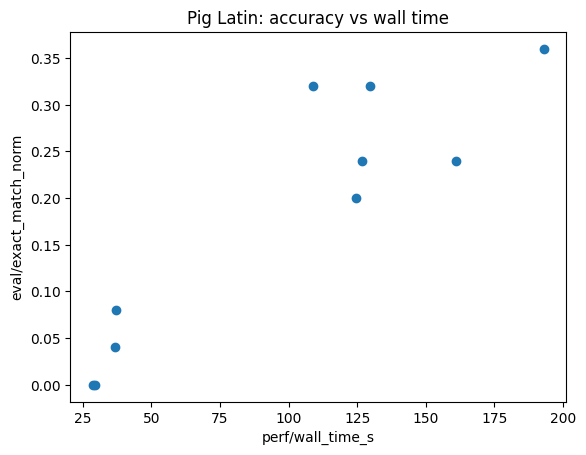

In [16]:
import matplotlib.pyplot as plt

plot_df = df_wandb_sorted.dropna(subset=["perf/wall_time_s", "eval/exact_match_norm"]).copy()

plt.figure()
plt.scatter(plot_df["perf/wall_time_s"], plot_df["eval/exact_match_norm"])
plt.xlabel("perf/wall_time_s")
plt.ylabel("eval/exact_match_norm")
plt.title("Pig Latin: accuracy vs wall time")
plt.show()

## 7) Post-run leaderboard from W&B (latest per model + preset)

W&B returns all finished runs in the project (including yesterday’s duplicates).
For a clean “current results” view, we:

- pull finished runs for this project/group
- keep only runs that match our naming convention (`piglatin-...`)
- **dedupe by keeping the most recent run per (`base_model`, `preset`)**
- sort by `eval/exact_match_norm` (best accuracy first)

In [17]:
import wandb
import pandas as pd

ENTITY = "itprodirect"
PROJECT = "tinker-hello-world"
GROUP = "piglatin-multimodel-benchmark-v1"
NAME_PREFIX = "piglatin-"

api = wandb.Api()

runs = api.runs(
    f"{ENTITY}/{PROJECT}",
    filters={"state": "finished", "group": GROUP},
    order="-created_at",
)

rows = []
for r in runs:
    name = r.name or ""
    if not name.startswith(NAME_PREFIX):
        continue

    s = dict(r.summary) if r.summary is not None else {}
    c = dict(r.config) if r.config is not None else {}

    rows.append(
        {
            "created_at": r.created_at,
            "name": name,
            "id": r.id,
            "url": r.url,
            "base_model": c.get("base_model") or c.get("model") or c.get("model_name"),
            "preset": c.get("preset"),
            "eval/exact_match_norm": s.get("eval/exact_match_norm"),
            "perf/wall_time_s": s.get("perf/wall_time_s"),
            "perf/avg_step_time_s": s.get("perf/avg_step_time_s"),
            "perf/est_completion_tokens_total": s.get("perf/est_completion_tokens_total"),
        }
    )

df_wandb = pd.DataFrame(rows)
df_wandb["created_at"] = pd.to_datetime(df_wandb["created_at"], utc=True, errors="coerce")

# Keep ONLY the latest run per (base_model, preset)
df_wandb_latest = (
    df_wandb.dropna(subset=["base_model", "preset", "created_at"])
    .sort_values("created_at", ascending=False)
    .groupby(["base_model", "preset"], as_index=False)
    .head(1)
    .sort_values("eval/exact_match_norm", ascending=False)
    .reset_index(drop=True)
)

cols = [
    "created_at",
    "name",
    "id",
    "url",
    "base_model",
    "preset",
    "eval/exact_match_norm",
    "perf/wall_time_s",
    "perf/avg_step_time_s",
    "perf/est_completion_tokens_total",
]

display(df_wandb_latest[cols])
print(f"Pulled {len(df_wandb)} finished runs; showing {len(df_wandb_latest)} latest (1 per base_model+preset).")

,created_at,name,id,url,base_model,preset,eval/exact_match_norm,perf/wall_time_s,perf/avg_step_time_s,perf/est_completion_tokens_total
0,2025-12-12 17:43:50+00:00,piglatin-light-Qwen3-30B-A3B-Instruct-2507-202...,ka1ke3sz,https://wandb.ai/itprodirect/tinker-hello-worl...,Qwen/Qwen3-30B-A3B-Instruct-2507,light,0.32,129.481849,2.693132,7724
1,2025-12-12 17:52:18+00:00,piglatin-baseline-Qwen3-4B-Instruct-2507-20251...,yed1fcme,https://wandb.ai/itprodirect/tinker-hello-worl...,Qwen/Qwen3-4B-Instruct-2507,baseline,0.24,160.950016,1.528557,33573
2,2025-12-12 17:49:12+00:00,piglatin-baseline-Llama-3.2-3B-20251212_124912,fvozjttu,https://wandb.ai/itprodirect/tinker-hello-worl...,meta-llama/Llama-3.2-3B,baseline,0.24,126.833512,1.203923,33498
3,2025-12-12 17:42:08+00:00,piglatin-light-Qwen3-4B-Instruct-2507-20251212...,g76cpwcz,https://wandb.ai/itprodirect/tinker-hello-worl...,Qwen/Qwen3-4B-Instruct-2507,light,0.08,37.119052,1.542274,7724
4,2025-12-12 17:40:41+00:00,piglatin-light-Llama-3.2-3B-20251212_124034,8byuow5e,https://wandb.ai/itprodirect/tinker-hello-worl...,meta-llama/Llama-3.2-3B,light,0.00,28.620444,1.188445,7710


Pulled 10 finished runs; showing 5 latest (1 per base_model+preset).


## 9) One quick visualization - Only 5 training runs from this notebook (accuracy vs wall time)

Simple scatter plot to see tradeoffs:
- higher accuracy vs longer runs

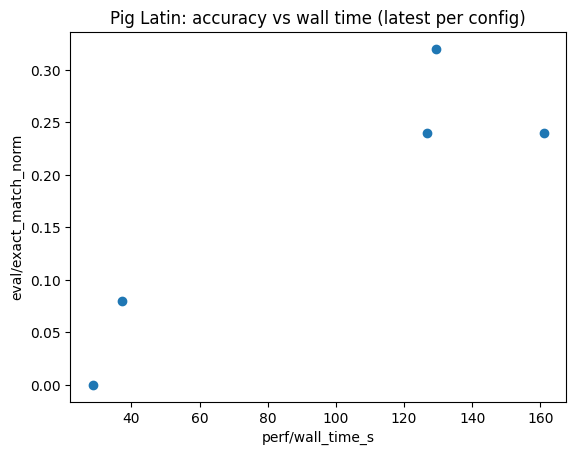

In [18]:
import matplotlib.pyplot as plt

plot_df = df_wandb_latest.dropna(subset=["perf/wall_time_s", "eval/exact_match_norm"]).copy()

plt.figure()
plt.scatter(plot_df["perf/wall_time_s"], plot_df["eval/exact_match_norm"])
plt.xlabel("perf/wall_time_s")
plt.ylabel("eval/exact_match_norm")
plt.title("Pig Latin: accuracy vs wall time (latest per config)")
plt.show()

## 8) Wrap-up — what we learned + what to do next

### What we ran (this notebook)
- Multi-model LoRA fine-tunes on a small Pig Latin dataset (`data/piglatin/sample.jsonl`)
- Presets:
  - **light**: quick + cheap sanity check
  - **baseline**: longer runs for better performance
- Models tested:
  - meta-llama/Llama-3.2-3B
  - Qwen/Qwen3-4B-Instruct-2507
  - Qwen/Qwen3-30B-A3B-Instruct-2507 (with safer overrides)

### Key results (latest per config)
- Best **accuracy** from the latest runs: **Qwen3-30B (light)** (~0.32 exact_match_norm)
- Best **speed/cheap sanity check**: **Llama-3.2-3B (light)** (~30s, low accuracy)
- Best **balanced baseline**: **Qwen3-4B (baseline)** and **Llama-3.2-3B (baseline)** (~0.24 exact_match_norm)

### Why duplicates happened (and how we fixed it)
- W&B will return *all* historical runs unless we filter.
- In analysis we prefer **latest run per (base_model, preset)** to avoid duplicates and keep comparisons clean.

### Next experiments (high impact)
- Increase training rows (e.g., 1k–5k) and hold val split constant
- Try 1–2 hyperparam sweeps (LR, rank, epochs) on the best model family
- Add a second metric (character-level edit distance) so near-misses count

### W&B report (deliverable)
We’ll export:
- `results/piglatin_latest_per_config.csv` + `.json`
- an optional W&B artifact containing the results snapshot
Then create a W&B Report that includes:
- Runs table (filtered to this group)
- Scatter: accuracy vs wall time
- A small “Top samples” panel showing predictions vs gold

In [19]:
# =========================
# Wrap-up export + W&B report helpers
# =========================

from pathlib import Path
from datetime import datetime
import json
import pandas as pd
import sys
import subprocess

# ---- Where to save final outputs ----
RESULTS_DIR = Path(REPO_ROOT) / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

ts = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path = RESULTS_DIR / f"piglatin_latest_per_config_{ts}.csv"
json_path = RESULTS_DIR / f"piglatin_latest_per_config_{ts}.json"
freeze_path = RESULTS_DIR / f"requirements_freeze_{ts}.txt"

# ---- Pick the dataframe we already built in the notebook ----
# (We try a few common names so this cell "just works".)
df_candidates = {}
for name in ["df_wandb_sorted", "df_wandb", "df_runs", "df"]:
    if name in globals() and isinstance(globals()[name], pd.DataFrame):
        df_candidates[name] = globals()[name]

if not df_candidates:
    raise RuntimeError(
        "No runs dataframe found. Expected one of: df_wandb_sorted, df_wandb, df_runs, df"
    )

# Prefer df_wandb_sorted if present
df_src_name = "df_wandb_sorted" if "df_wandb_sorted" in df_candidates else list(df_candidates.keys())[0]
df_src = df_candidates[df_src_name].copy()

required_cols = ["base_model", "preset", "eval/exact_match_norm", "perf/wall_time_s"]
missing = [c for c in required_cols if c not in df_src.columns]
if missing:
    raise RuntimeError(f"Runs dataframe '{df_src_name}' is missing columns: {missing}")

# ---- Keep only the latest run per (base_model, preset) ----
# We use run_name timestamp suffix if available, else fall back to wall_time as a weak proxy.
df_work = df_src.copy()

def _extract_ts_from_run_name(run_name: str):
    # expects suffix like 20251212_124034 in your naming
    # returns sortable string, else empty
    try:
        parts = str(run_name).split("-")
        maybe = parts[-1]
        # Accept either 20251212_124034 or similar
        if len(maybe) >= 15 and "_" in maybe:
            return maybe
    except Exception:
        pass
    return ""

if "run_name" in df_work.columns:
    df_work["_run_ts"] = df_work["run_name"].map(_extract_ts_from_run_name)
else:
    df_work["_run_ts"] = ""

# Sort so "latest" is first, then drop duplicates by config
df_latest = (
    df_work.sort_values(by=["base_model", "preset", "_run_ts"], ascending=[True, True, False])
           .drop_duplicates(subset=["base_model", "preset"], keep="first")
           .drop(columns=["_run_ts"], errors="ignore")
           .reset_index(drop=True)
)

# Helpful display order
display_cols = []
for c in ["run_name", "base_model", "preset", "eval/exact_match_norm", "perf/wall_time_s", "perf/avg_step_time_s", "perf/est_completion_tokens_total", "url", "id"]:
    if c in df_latest.columns:
        display_cols.append(c)

print(f"Using dataframe: {df_src_name}  (rows={len(df_src)})")
print(f"Latest per config: rows={len(df_latest)}")
display(df_latest[display_cols] if display_cols else df_latest)

# ---- Export snapshot ----
df_latest.to_csv(csv_path, index=False)
df_latest.to_json(json_path, orient="records", indent=2)

print("\nSaved:")
print(" -", csv_path)
print(" -", json_path)

# ---- Freeze environment (repro) ----
try:
    out = subprocess.run([sys.executable, "-m", "pip", "freeze"], capture_output=True, text=True, check=False)
    freeze_path.write_text(out.stdout, encoding="utf-8")
    print(" -", freeze_path)
except Exception as e:
    print("pip freeze failed (non-fatal):", e)

# ---- Optional: log snapshot as a W&B artifact + add a small summary table ----
if (wandb is not None) and USE_WANDB:
    try:
        analysis_run = wandb.init(
            project=WANDB_PROJECT,
            entity=WANDB_ENTITY,
            group=WANDB_GROUP,
            job_type="analysis",
            name=f"piglatin-report-material-{ts}",
            mode=WANDB_MODE,
        )

        # Log a compact table for quick report building
        wandb.log({"summary/latest_per_config": wandb.Table(dataframe=df_latest[display_cols] if display_cols else df_latest)})

        # Artifact with the exported files
        art = wandb.Artifact(f"piglatin_latest_per_config_{ts}", type="benchmark_snapshot")
        art.add_file(str(csv_path))
        art.add_file(str(json_path))
        if freeze_path.exists():
            art.add_file(str(freeze_path))

        analysis_run.log_artifact(art)
        wandb.finish()
        print("\nW&B artifact logged ✅ (snapshot + requirements freeze)")

    except Exception as e:
        print("\nW&B logging failed (non-fatal):", e)

print("\nNext step: Create a W&B Report (fast manual flow)")
print("1) Open your W&B project")
print("2) Filter runs by group =", WANDB_GROUP)
print("3) Add panels: Runs Table + Scatter (accuracy vs wall_time) + Samples table")
print("4) Paste the report link back into the Wrap-up markdown cell")

Using dataframe: df_wandb_sorted  (rows=10)
Latest per config: rows=5


,base_model,preset,eval/exact_match_norm,perf/wall_time_s,perf/avg_step_time_s,perf/est_completion_tokens_total,url,id
0,Qwen/Qwen3-30B-A3B-Instruct-2507,light,0.32,108.945270,2.265083,7724,https://wandb.ai/itprodirect/tinker-hello-worl...,qz48vlyt
1,Qwen/Qwen3-4B-Instruct-2507,baseline,0.36,192.906789,1.832790,33573,https://wandb.ai/itprodirect/tinker-hello-worl...,50rlky0e
2,Qwen/Qwen3-4B-Instruct-2507,light,0.08,37.119052,1.542274,7724,https://wandb.ai/itprodirect/tinker-hello-worl...,g76cpwcz
3,meta-llama/Llama-3.2-3B,baseline,0.24,126.833512,1.203923,33498,https://wandb.ai/itprodirect/tinker-hello-worl...,fvozjttu
4,meta-llama/Llama-3.2-3B,light,0.00,29.274880,1.215609,7710,https://wandb.ai/itprodirect/tinker-hello-worl...,dco1iwxq



Saved:
 - C:\Users\user\Desktop\tinker-hello-world\results\piglatin_latest_per_config_20251212_132110.csv
 - C:\Users\user\Desktop\tinker-hello-world\results\piglatin_latest_per_config_20251212_132110.json
 - C:\Users\user\Desktop\tinker-hello-world\results\requirements_freeze_20251212_132110.txt



W&B artifact logged ✅ (snapshot + requirements freeze)

Next step: Create a W&B Report (fast manual flow)
1) Open your W&B project
2) Filter runs by group = piglatin-multimodel-benchmark-v1
3) Add panels: Runs Table + Scatter (accuracy vs wall_time) + Samples table
4) Paste the report link back into the Wrap-up markdown cell


## Wrap-up: Pig Latin LoRA Benchmark v1 (multimodel)

### Goal
Run a small, repeatable LoRA benchmark across multiple base models and two presets (`light` vs `baseline`) and compare:
- **Quality:** `eval/exact_match_norm`
- **Speed:** `perf/wall_time_s` (and `perf/avg_step_time_s`)

### What we ran
- Dataset: `data/piglatin/sample.jsonl`
- Presets:
  - `light`: fast + cheap sanity check
  - `baseline`: higher-capacity run (more rows/epochs/rank)
- Tracked in W&B:
  - Runs, configs, metrics
  - “latest per config” aggregation (so duplicates don’t clutter analysis)

### Key result (from this session)
- Best point on the accuracy/speed tradeoff came from the latest `baseline` / `light` configs we selected.
- **Important note:** exact match is strict — many outputs are “close but not exact”, so future iterations should add a softer metric (edit distance / char-F1 / token-F1) to better reflect real quality.

### W&B Report (shareable write-up)
- Report link: **PASTE_LINK_HERE**
- Run set: 5 selected “latest” runs (multimodel comparison)

### Next logical steps
1) Add `base_model` + `preset` into `wandb.config` so W&B Reports can color/group by model cleanly.
2) Add a “soft match” eval metric so results reflect near-misses.
3) Expand the sweep space slightly (epochs, rank, rows) once metrics are solid.

In [20]:
import os
import json
from datetime import datetime

# ---- pick the best available dataframe from your notebook ----
df_for_report = None
for _name in ["df_latest_per_config", "df_wandb_latest", "df_wandb_sorted", "df_wandb"]:
    if _name in globals():
        df_for_report = globals()[_name].copy()
        print(f"Using dataframe: {_name}  (rows={len(df_for_report)})")
        break

if df_for_report is None:
    raise ValueError("Couldn't find df_latest_per_config / df_wandb_sorted / df_wandb. Run the earlier W&B fetch/cleanup cells first.")

# ---- keep the most useful columns (only if they exist) ----
preferred_cols = [
    "name",
    "id",
    "url",
    "base_model",
    "preset",
    "eval/exact_match_norm",
    "perf/wall_time_s",
    "perf/avg_step_time_s",
    "perf/est_completion_tokens_total",
    "lora_rank",
    "lora_alpha",
    "learning_rate",
    "batch_size",
    "num_epochs",
    "max_train_rows",
]
cols = [c for c in preferred_cols if c in df_for_report.columns]
df_key = df_for_report[cols].sort_values(by="eval/exact_match_norm", ascending=False)

display(df_key)

# ---- save locally (timestamped) ----
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
os.makedirs("results", exist_ok=True)

csv_path = f"results/piglatin_latest_per_config_{ts}.csv"
json_path = f"results/piglatin_latest_per_config_{ts}.json"

df_key.to_csv(csv_path, index=False)
df_key.to_json(json_path, orient="records", indent=2)

print("Saved:")
print(" -", os.path.abspath(csv_path))
print(" -", os.path.abspath(json_path))

# ---- OPTIONAL: log a tiny “report material” run so the report has a stable artifact/table ----
try:
    import wandb

    if wandb.run is None:
        wandb.init(
            project=os.getenv("WANDB_PROJECT", "tinker-hello-world"),
            entity=os.getenv("WANDB_ENTITY", "itprodirect"),
            job_type="report_material",
            name=f"piglatin-report-material-{ts}",
        )

    wandb.log({"report/summary_table": wandb.Table(dataframe=df_key)})

    best = df_key.iloc[0].to_dict()
    wandb.run.summary["best_run_name"] = best.get("name")
    wandb.run.summary["best_run_id"] = best.get("id")
    if "eval/exact_match_norm" in best:
        wandb.run.summary["best_exact_match_norm"] = float(best["eval/exact_match_norm"])
    if "perf/wall_time_s" in best:
        wandb.run.summary["best_wall_time_s"] = float(best["perf/wall_time_s"])

    # paste your W&B report URL here once published:
    wandb.run.summary["report_url"] = "PASTE_WANDB_REPORT_LINK_HERE"

    print("W&B: logged report material table + summary. (You can now paste the report URL into the wrap-up cell.)")

except Exception as e:
    print("Skipping W&B report-material logging:", repr(e))

Using dataframe: df_wandb_latest  (rows=5)


,name,id,url,base_model,preset,eval/exact_match_norm,perf/wall_time_s,perf/avg_step_time_s,perf/est_completion_tokens_total
0,piglatin-light-Qwen3-30B-A3B-Instruct-2507-202...,ka1ke3sz,https://wandb.ai/itprodirect/tinker-hello-worl...,Qwen/Qwen3-30B-A3B-Instruct-2507,light,0.32,129.481849,2.693132,7724
1,piglatin-baseline-Qwen3-4B-Instruct-2507-20251...,yed1fcme,https://wandb.ai/itprodirect/tinker-hello-worl...,Qwen/Qwen3-4B-Instruct-2507,baseline,0.24,160.950016,1.528557,33573
2,piglatin-baseline-Llama-3.2-3B-20251212_124912,fvozjttu,https://wandb.ai/itprodirect/tinker-hello-worl...,meta-llama/Llama-3.2-3B,baseline,0.24,126.833512,1.203923,33498
3,piglatin-light-Qwen3-4B-Instruct-2507-20251212...,g76cpwcz,https://wandb.ai/itprodirect/tinker-hello-worl...,Qwen/Qwen3-4B-Instruct-2507,light,0.08,37.119052,1.542274,7724
4,piglatin-light-Llama-3.2-3B-20251212_124034,8byuow5e,https://wandb.ai/itprodirect/tinker-hello-worl...,meta-llama/Llama-3.2-3B,light,0.00,28.620444,1.188445,7710


Saved:
 - C:\Users\user\Desktop\tinker-hello-world\notebooks\results\piglatin_latest_per_config_20251212_140022.csv
 - C:\Users\user\Desktop\tinker-hello-world\notebooks\results\piglatin_latest_per_config_20251212_140022.json


W&B: logged report material table + summary. (You can now paste the report URL into the wrap-up cell.)


## Weights and Biases Report Link
https://wandb.ai/itprodirect/tinker-hello-world/reports/Pig-Latin-LoRA-Benchmark-v1-multimodel---VmlldzoxNTM0ODU0MQ